# Урок 6. Градиентный бустинг. AdaBoost

## Практическое задание

### Задание 1

Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров. 

### Решение 1

In [1]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection

import numpy as np
X, y = load_diabetes(return_X_y=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

$$a_{N}(x) = \sum^{N}_{n=1}\gamma_{n}b_{n}(x).$$

In [2]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [8]:



def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)


def bias(y, z):
    return - 2 * (z - y)


def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors


def show_error_plot(depth_tree_set, val_name):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Trees number')
    plt.ylabel('MSE')
    
    
    for i in range(len(depth_tree_set)):
        val = depth_tree_set[i][0]
        n_trees = len(depth_tree_set[i][1])
        train_err = depth_tree_set[i][2]
        test_err = depth_tree_set[i][3]
        
        min_train_error = float('inf')
        min_test_error = float('inf')
        min_diff = float('inf')
        trees_count = 0
        best_val = 0
        i = 0
        for tr_e, t_e in zip(train_err, test_err):
            #if tr_e < min_train_error and t_e < min_test_error:
            diff = abs(tr_e - t_e)
            if diff < min_diff:
                min_train_error = tr_e
                min_test_error = t_e
                    
                best_val = val
                trees_count = i
                min_diff = diff
            i+=1
        print(f"trees_count:{trees_count}, best_{val_name}:{best_val}")
        print(f"min_diff:{round(min_diff, 2)}, train_err:{round(min_train_error, 2)}, test_err:{round(min_test_error, 2)}")
        print()
            
        plt.xlim(0, n_trees)
        plt.plot(list(range(n_trees)), train_err, label=f'train error, {val_name} {val}')
        plt.plot(list(range(n_trees)), test_err, label=f'test error, {val_name} {val}')
    
    #print(f"best_trees:{best_trees}, best_{val_name}:{best_val}, min_diff:{min_diff}min_test_error:{min_test_error}")
    plt.legend(loc='upper right')
    plt.show()


def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    # plt.xlim(0, n_trees)
    plt.plot(list(range(1, n_trees+1)), train_err, label='train error')
    plt.plot(list(range(1, n_trees+1)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()


def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth}'
          f' с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth}'
          f' с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

     
def test_depth(n_trees, n_depth, eta):
    coefs = [1] * n_trees
    depth_tree_list = []
    for depth in n_depth:
        trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta)
        depth_tree_list.append([depth, trees, train_errors, test_errors])
    show_error_plot(depth_tree_list, "depth")
    return depth_tree_list


def test_eta(n_trees, depth, eta):
    coefs = [1] * n_trees
    eta_tree_list = []
    for e in eta:
        trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, e)
        eta_tree_list.append([e, trees, train_errors, test_errors])
    show_error_plot(eta_tree_list, "eta")
    return eta_tree_list 

trees_count:3, best_depth:4
min_diff:1871.41, train_err:10928.54, test_err:12799.95

trees_count:3, best_depth:5
min_diff:2194.83, train_err:10600.06, test_err:12794.89

trees_count:2, best_depth:6
min_diff:2578.5, train_err:15366.44, test_err:17944.95

trees_count:0, best_depth:7
min_diff:2659.79, train_err:28406.53, test_err:31066.32



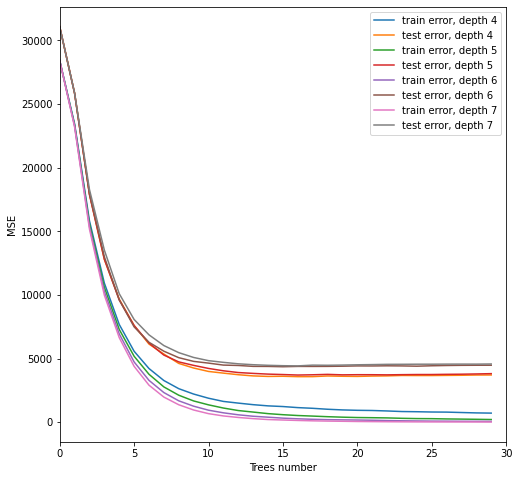

In [4]:
n_trees = 30
n_depth = np.arange(start=4, stop=8, step=1)
n_eta = 0.1

tree_list = test_depth(n_trees, n_depth, n_eta)

trees_count:2, best_eta:0.005
min_diff:2630.19, train_err:27617.34, test_err:30247.52

trees_count:2, best_eta:0.05
min_diff:2467.39, train_err:21250.88, test_err:23718.27

trees_count:2, best_eta:0.1
min_diff:2289.82, train_err:15582.89, test_err:17872.71

trees_count:1, best_eta:0.5
min_diff:2071.31, train_err:8461.69, test_err:10533.01



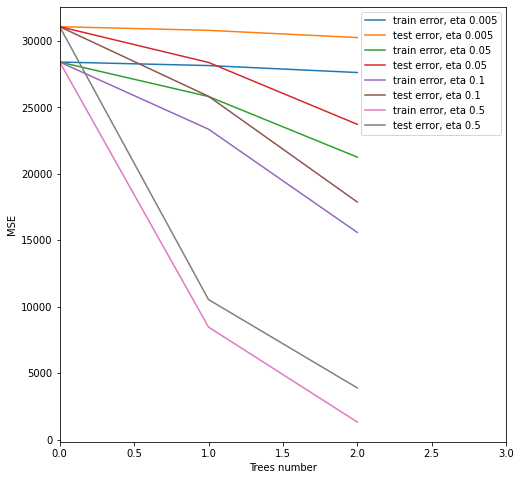

In [5]:
# Лучшее:
# trees_count:3, best_depth:5
# min_diff:2194.83, train_err:10600.06, test_err:12794.89

n_trees = 3
n_depth = 5
n_eta = [0.005, 0.05, 0.1, 0.5]

tree_list = test_eta(n_trees, n_depth, n_eta)

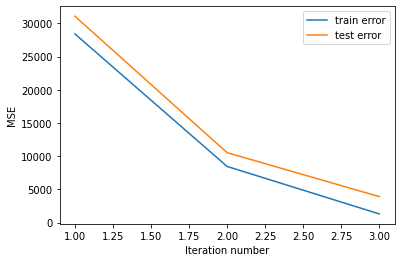

Ошибка алгоритма из 3 деревьев глубиной 5 с шагом 0.5 на тренировочной выборке: 910
Ошибка алгоритма из 3 деревьев глубиной 5 с шагом 0.5 на тестовой выборке: 4568


In [12]:
# Лучшее:
# trees_count:1, best_eta:0.5
# min_diff:2071.31, train_err:8461.69, test_err:10533.01

n_trees = 3
coefs = [1] * n_trees
max_depth = 5
eta = 0.5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
get_error_plot(n_trees, train_errors, test_errors)
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)